In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

import math
import torch
from torch import nn
from torch.nn.functional import softmax

from load_translation_data import load_data_nmt
from visualization import TrainingVisualizer
from transformer import PositionalEncoding,AddNorm,PositionWiseFFN,grad_clipping,sequence_mask,MaskedSoftmaxCELoss

In [2]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
num_hiddens = 256
num_heads = 8
dropout = 0.5

batch_size = 64
seq_size = 50

normalized_shape = [num_hiddens]

ffn_num_hiddens = 128
num_layers = 6

i = 0 

num_epochs = 100
lr = 0.01

In [4]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, seq_size)
src_vocab_size = len(src_vocab)
tgt_vocab_size = len(tgt_vocab)
src_vocab_size, tgt_vocab_size

(184, 201)

In [5]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，seq_size，#_size*num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1) # (batch_size，seq_size，num_heads，#_size) 
    X = X.permute(0, 2, 1, 3) # (batch_size，num_heads，seq_size, #_size)
    X = X.reshape(-1, X.shape[2], X.shape[3]) # 最终输出的形状: (batch_size*num_heads, seq_size, #_size)
    return X

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    # 输出维度：(batch_size*num_heads, seq_size, value_size)
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2]) # (batch_size, num_heads, seq_size, value_size)
    X = X.permute(0, 2, 1, 3) # (batch_size, seq_size, num_heads, value_size)
    X = X.reshape(X.shape[0], X.shape[1], -1) # (batch_size, seq_size, num_heads*value_size)
    return X

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs): 
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_heads = num_heads
        self.dropout = nn.Dropout(dropout)
        self.key_size = num_hiddens / num_heads
        self.W_q = nn.Linear(num_hiddens, num_hiddens, bias=bias) # 实际上：(embedding_size, query_size*num_heads)
        self.W_k = nn.Linear(num_hiddens, num_hiddens, bias=bias) # 实际上：(embedding_size, key_size*num_heads)
        self.W_v = nn.Linear(num_hiddens, num_hiddens, bias=bias) # 实际上：(embedding_size, value_size*num_heads)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias) # 实际上：(value_size*num_heads, output_size)

    def forward(self, X_queries, X_keys, X_values, valid_lens=None):
        queries = self.W_q(X_queries) # (batch_size, seq_size, query_size*num_heads)
        keys = self.W_k(X_keys) # (batch_size, seq_size, key_size*num_heads)
        values = self.W_v(X_values) # (batch_size, seq_size, value_size*num_heads)

        queries = transpose_qkv(queries, self.num_heads) # (batch_size*num_heads, seq_size, query_size)
        keys = transpose_qkv(keys, self.num_heads) # (batch_size*num_heads, seq_size, key_size)
        values = transpose_qkv(values, self.num_heads) # (batch_size*num_heads, seq_size, value_size)

        keys = keys.transpose(1, 2) # 交换keys的第一个和第二个维度（从0开始） -> (batch_size*num_heads, key_size, seq_size)
        scores = torch.bmm(queries, keys) # 1.输出维度：(batch_size*num_heads, seq_size, seq_size) 2.我们需要保证 query_size = key_size！ 3.在decoder中是(batch_size*num_heads, seq_size, seq_size*(i+1))
        scores = scores / torch.tensor([math.sqrt(self.key_size)]).to(scores.device) # 除以 根号下(key_size)；输出维度：(batch_size*num_heads, seq_size, seq_size)
        
        attention_weights = self.masked_softmax(scores, valid_lens)
        # print(attention_weights, "####################\n")
        attention_weights = self.dropout(attention_weights)

        attention_outputs = torch.bmm(attention_weights, values) # (batch_size*num_heads, seq_size, seq_size) 与 (batch_size*num_heads, seq_size, value_size) 相乘 -> (batch_size*num_heads, seq_size, value_size)

        # 组合多头。此时的Z的维度为：(batch_size*num_heads, seq_size, value_size)，我们需要进行一定的转化
        attention_outputs_concat = transpose_output(attention_outputs, self.num_heads) # Z_concat的维度：(batch_size, seq_size, num_heads*value_size)

        outputs = self.W_o(attention_outputs_concat) # outputs的维度：(batch_size, seq_size, num_hiddens)
        # print(outputs, "####################\n")
        return outputs

    def masked_softmax(self, scores, valid_lens):
        # 输入 scores 的维度：(batch_size*num_heads, seq_size, seq_size)
        # 输入 valid_lens 的维度：1.(1, batch_size) 行向量；2.(seq_size, seq_size)
        dim1, seq_size, _ = scores.shape
        if valid_lens is None:
            return nn.functional.softmax(scores, dim=-1) 
        else: 
            if valid_lens.dim() == 1:
                valid_lens = valid_lens.repeat_interleave(self.num_heads, dim=0)
                mask = torch.arange(seq_size, device=scores.device)[None, :] < valid_lens[:, None] 
                scores[~mask] = -100000 
                # scores[~mask] = float('-inf')
            elif valid_lens.dim() == 2:
                valid_lens = valid_lens.bool()  
                mask = valid_lens.unsqueeze(0).unsqueeze(0).repeat(int(dim1/self.num_heads), self.num_heads, 1, 1)
                print(mask.shape)
                mask = mask.view(dim1, seq_size, seq_size)
                scores[mask] = -100000
                # scores[mask] = float('-inf')

            return nn.functional.softmax(scores, dim=-1)

In [13]:
# test
# scores = torch.rand(batch_size*num_heads, seq_size, seq_size)

# valid_lens = torch.tensor([3,4,5])
# valid_lens = valid_lens.repeat_interleave(num_heads, dim=0)
# mask = torch.arange(seq_size)[None, :] < valid_lens[:, None] 
# scores[~mask] = -100000 
# print(mask, "\n", scores)

# dec_valid_lens = torch.triu(torch.ones(seq_size, seq_size), diagonal=1)  
# dec_valid_lens = dec_valid_lens.bool() 
# mask = dec_valid_lens.unsqueeze(0).unsqueeze(0).repeat(batch_size, num_heads, 1, 1)
# mask = mask.view(batch_size*num_heads, seq_size, seq_size)
# scores[mask] = -100000
# print(mask, "\n", scores)

In [14]:
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(normalized_shape, dropout)
        self.ffn = PositionWiseFFN(num_hiddens, ffn_num_hiddens)
        self.addnorm2 = AddNorm(normalized_shape, dropout)

    def forward(self, X, valid_lens):
        # print("encoder的多头注意力")
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(nn.Module):
    """Transformer编码器"""
    def __init__(self, src_vocab_size, num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embedding_size = num_hiddens
        self.embedding = nn.Embedding(src_vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i), EncoderBlock(num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.embedding_size)) 
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens) 
        return X

In [15]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(normalized_shape, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(normalized_shape, dropout)
        self.ffn = PositionWiseFFN(num_hiddens, ffn_num_hiddens)
        self.addnorm3 = AddNorm(normalized_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        if state[2][self.i] is None: 
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1) 
        state[2][self.i] = key_values 

        # dec_valid_lens的作用是未来掩码，但目前我不清楚是如何运作的
        if self.training: 
            _, seq_size, _ = X.shape
            # dec_valid_lens = torch.arange(1, seq_size + 1, device=X.device).repeat(batch_size, 1) 
            dec_valid_lens = torch.triu(torch.ones(seq_size, seq_size, device=X.device), diagonal=1)
        else: 
            dec_valid_lens = None # 构建dec_valid_lens，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。

        # 自注意力
        # print("decoder的第一个多头注意力")
        X1 = self.attention1(X, key_values, key_values, dec_valid_lens) # 第一次的输入还是X,X,X
        X2 = self.addnorm1(X, X1)
        # 编码器－解码器注意力。
        # print("decoder的第二个多头注意力")
        X3 = self.attention2(X2, enc_outputs, enc_outputs, enc_valid_lens) # 这里如何理解？？？？？？
        Y = self.addnorm2(X2, X3)
        return self.addnorm3(Y, self.ffn(Y)), state

class TransformerDecoder(nn.Module):
    def __init__(self, tgt_vocab_size, num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embedding_size = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(tgt_vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i), DecoderBlock(num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, dropout, i))
        self.dense = nn.Linear(num_hiddens, tgt_vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        state = [enc_outputs, enc_valid_lens, [None] * self.num_layers]
        return state

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.embedding_size))
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        return self.dense(X), state

In [16]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, X_valid_len):
        enc_outputs = self.encoder(enc_X, X_valid_len)
        dec_state = self.decoder.init_state(enc_outputs, X_valid_len)
        return self.decoder(dec_X, dec_state)

In [17]:
def train_seq2seq(model, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    
    def xavier_init_weights(m): # 使用 Xavier 均匀分布初始化 Transformer 模型中的权重。
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)

    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = MaskedSoftmaxCELoss()
    model.train()
    visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Value', title='Train transformer_scratch', legend=['Train Loss'])
    
    for epoch in range(num_epochs):
        total_loss = 0
        for X, X_valid_len, Y, Y_valid_len in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = X.to(device), X_valid_len.to(device), Y.to(device), Y_valid_len.to(device)
            # print(X, X_valid_len, Y, Y_valid_len, "#######################################################")
            
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1) # Y.shape[0]为batch_size，
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学。dim=0，加行；dim=1，加列。Y[:, :-1]选择所有行，列从第一列到倒数第二列

            # X_valid_len = None # #########################################################################################
            Y_hat, _ = model(X, dec_input, X_valid_len) # 编码器输入：(X, X_valid_len)；解码器输入：(dec_input, 初始化的state)
            # print(Y_hat)
            loss = criterion(Y_hat, Y, Y_valid_len)
            # print(loss)
            total_loss+=loss.sum().item()
            loss.sum().backward()	
            grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            
        visualizer.add(epoch, [total_loss])

torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 50, 50])
torch.Size([64, 8, 5


KeyboardInterrupt



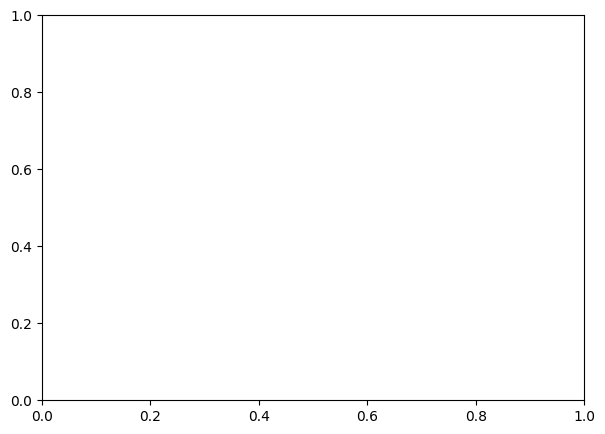

In [18]:
encoder = TransformerEncoder(src_vocab_size, num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, num_layers, dropout)
decoder = TransformerDecoder(tgt_vocab_size, num_hiddens, num_heads, normalized_shape, ffn_num_hiddens, num_layers, dropout)

model = EncoderDecoder(encoder, decoder)

train_seq2seq(model, train_iter, lr, num_epochs, tgt_vocab, device)